In [ ]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
from prettytable import PrettyTable
from astropy.io import fits
from datetime import datetime, timedelta
import matplotlib.image as mpimg
from astropy.stats import sigma_clip
from scipy.signal import butter, sosfiltfilt
from scipy import fftpack


### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

In [2]:
# Parameters
fs = 1000  # frequency sample
t = np.arange(0, 1, 1/fs)  # time array, 1 second of data

# 5.5 Hz  
freq1 = 5.5
sig5hz = np.sin(2 * np.pi * freq1 * t)
bartlett = np.bartlett(len(t))
sig5hzwindow = sig5hz * bartlett #leekage

# Dirty 60 Hz 
freq2 = 60
clean60 = np.sin(2 * np.pi * freq2 * t)
highnoise = 0.1 * np.sin(2 * np.pi * 500 * t)
transientspike = 0.5 * (np.random.random(len(t)) > 0.99).astype(float)
dirty60 = clean60 + highnoise + transientspike + (0.2 * np.random.normal(0, 1, len(t)))

# White Noise
whitenoise = np.random.normal(0, 0.5, len(t))

#i hope i did this right based off the website given 
# Brown Noise
freqs = np.fft.fftfreq(len(t), 1/fs)
beta = 2
scaling = 1 / ((np.abs(freqs) +1e-8)** (beta / 2)) #avoiding div by 0 errors and this worked
scaling[0] = 0
bnfreq = np.fft.fft(whitenoise) * scaling
brownnoise = np.fft.ifft(bnfreq).real

# Pink Noise (Deterministic 1/f Noise)
pinknoise = np.zeros(len(t))
pinknoise[0] = np.random.rand()
for i in range(1, len(t)):
    pinknoise[i] = (pinknoise[i-1] + pinknoise[i-1]**2) % 1
pinknoise -= 0.5


sumsignal = sig5hzwindow + dirty60 + whitenoise + brownnoise + pinknoise

color_map = {
    "5.5Hz": "lightblue",
    "Dirty60": "olivedrab",
    "Whitenoise": "gray",
    "Brownnoise": "brown",
    "Pinknoise": "deeppink"
}


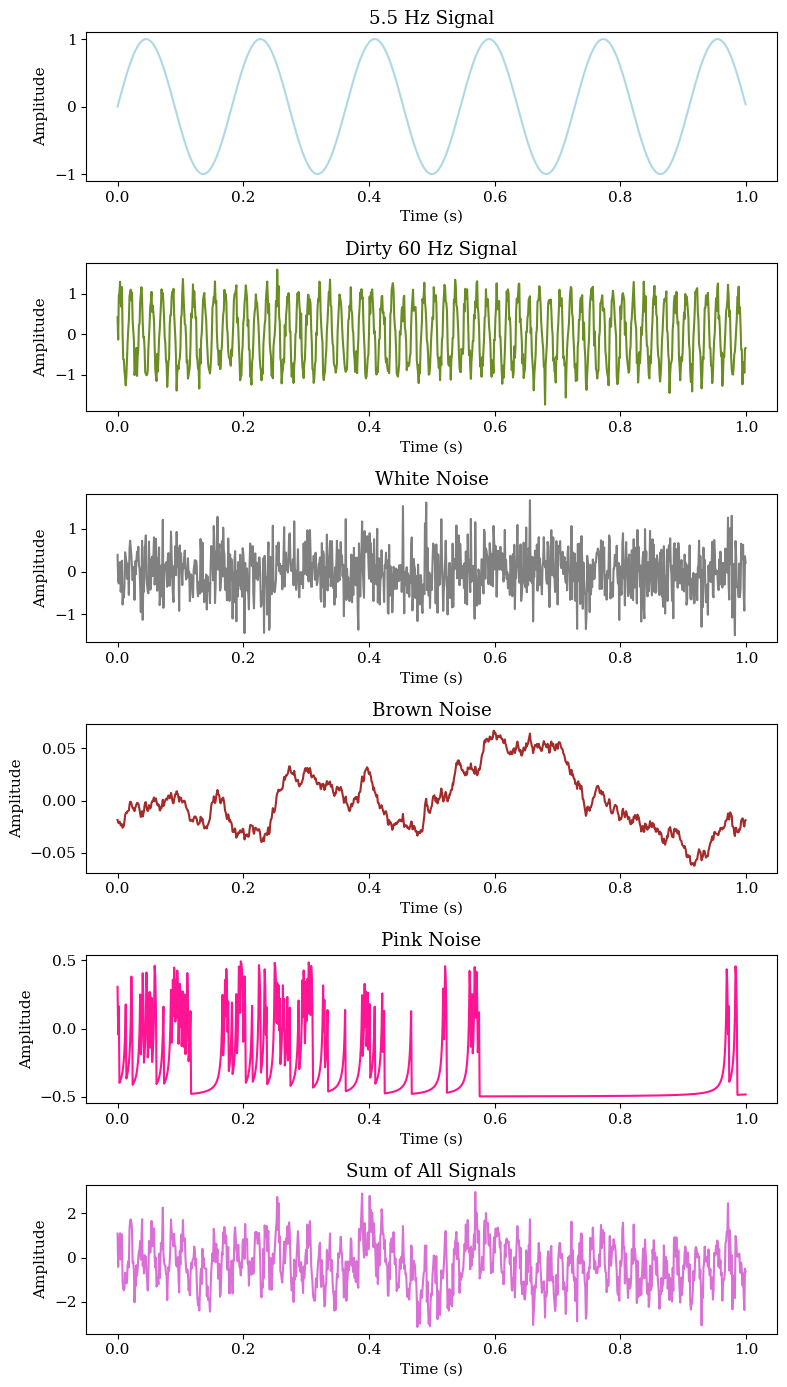

In [3]:
#part a
with plt.rc_context({'font.size': 11, 'font.family': 'serif'}):
    fig, ax = plt.subplots(6, 1, figsize=(8, 14))

    ax[0].plot(t, sig5hz, color=color_map["5.5Hz"])
    ax[0].set_title("5.5 Hz Signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(t, dirty60, color=color_map["Dirty60"])
    ax[1].set_title("Dirty 60 Hz Signal")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Amplitude")

    ax[2].plot(t, whitenoise, color=color_map["Whitenoise"])
    ax[2].set_title("White Noise")
    ax[2].set_xlabel("Time (s)")
    ax[2].set_ylabel("Amplitude")

    ax[3].plot(t, brownnoise, color=color_map["Brownnoise"])
    ax[3].set_title("Brown Noise")
    ax[3].set_xlabel("Time (s)")
    ax[3].set_ylabel("Amplitude")

    ax[4].plot(t, pinknoise, color=color_map["Pinknoise"])
    ax[4].set_title("Pink Noise")
    ax[4].set_xlabel("Time (s)")
    ax[4].set_ylabel("Amplitude")

    ax[5].plot(t, sumsignal, color="orchid")
    ax[5].set_title("Sum of All Signals")
    ax[5].set_xlabel("Time (s)")
    ax[5].set_ylabel("Amplitude")

    plt.tight_layout()  # kisses kisses mwah mwah, love this format makes life so easy
    plt.show()



In [4]:
#part b
noise_streams = {'Whitenoise': whitenoise, 'Brownnoise': brownnoise, 'Pinknoise': pinknoise, 'Dirty60': dirty60, '5.5Hz': sig5hzwindow}
stddevs = {}
for3sigma = {}

for name, stream in noise_streams.items():
    std = np.std(stream)
    stddevs[name] = std
    above3sig = np.sum(stream > 3 * std)
    below3sig = np.sum(stream < -3 * std)
    for3sigma[name] = (above3sig, below3sig)

table = PrettyTable()
table.field_names = ["Noise Type", "Std Dev", "Above 3σ", "Below 3σ"] #idk y but i can only use unicode in these tables??

for name in noise_streams.keys():
    table.add_row([name, f"{stddevs[name]:.4f}", for3sigma[name][0], for3sigma[name][1]])

# Print the table
print("Standard Deviation and 3-Sigma Counts")
print(table)


Standard Deviation and 3-Sigma Counts
+------------+---------+----------+----------+
| Noise Type | Std Dev | Above 3σ | Below 3σ |
+------------+---------+----------+----------+
| Whitenoise |  0.5079 |    3     |    0     |
| Brownnoise |  0.0293 |    0     |    0     |
| Pinknoise  |  0.2608 |    0     |    0     |
|  Dirty60   |  0.7329 |    0     |    0     |
|   5.5Hz    |  0.4091 |    0     |    0     |
+------------+---------+----------+----------+


C:\Users\Henna\AppData\Local\Temp\ipykernel_29768\536984259.py:12: RuntimeWarning: divide by zero encountered in log
  return -alpha * np.log(x) + logC


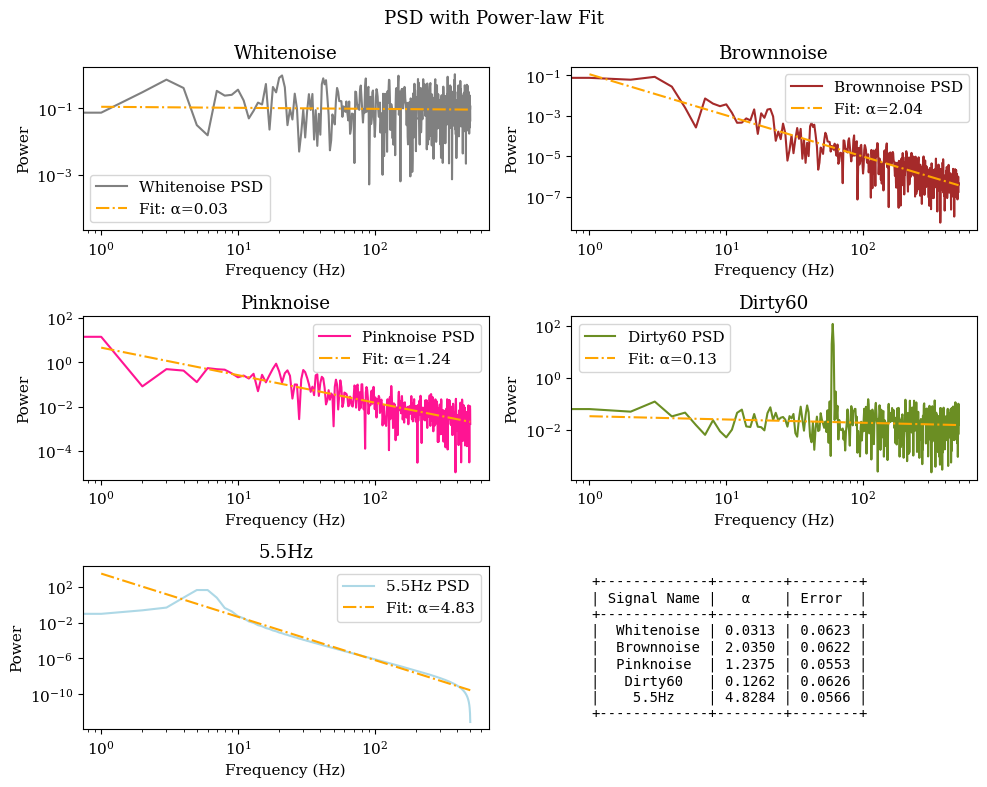

In [22]:
#part c and d

with plt.rc_context({'font.size': 11, 'font.family': 'serif'}):
    def plotpsd(signal, fs, window=None):
        siglen = len(signal)
        yfft = fft(signal * window) if window is not None else fft(signal)
        xfft = fftfreq(siglen, 1 / fs)[:siglen // 2]
        psd = 2.0 / siglen * np.abs(yfft[:siglen // 2]) ** 2
        return xfft, psd

    def powerlaw(x, alpha, logC):
        return -alpha * np.log(x) + logC

    slopes = {}
    errors = {}

    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle("PSD with Power-law Fit")

    for i, (name, stream) in enumerate(noise_streams.items()):
        xfft, psd = plotpsd(stream, fs, bartlett)
        
        xfftshape = xfft[1:] 
        psdshape = psd[1:]
        
        logpsd = np.log(psdshape)
        
        fitparam, covmat = curve_fit(powerlaw, xfftshape, logpsd)
        alpha, logC = fitparam
        C = np.exp(logC)  
        perr = np.sqrt(np.diag(covmat))
        
        slopes[name] = alpha
        errors[name] = perr[0]
        
        plot_color = color_map.get(name)
        ax = axs[i // 2, i % 2]  
        ax.loglog(xfft, psd, label=f'{name} PSD', color=plot_color)
        ax.loglog(xfft, np.exp(powerlaw(xfft, *fitparam)), label=f'Fit: α={alpha:.2f}', linestyle='-.', color="Orange")
        ax.set_title(f"{name}")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Power")
        ax.legend()

   #i wanted to put the table in the empty plot space
    if len(noise_streams) < 6:
        table = PrettyTable()
        table.field_names = ["Signal Name", "α", "Error"]

        for name in slopes.keys():
            table.add_row([name, f"{slopes[name]:.4f}", f"{errors[name]:.4f}"])

        tablestr = table.get_string()

        tableax = axs[-1, -1] 
        tableax.axis('off')  

        tableax.text(0.05, 0.95, tablestr, fontsize=10, va='top', ha='left', family='monospace')

    plt.tight_layout()#saving the day yet again
    plt.show()


C:\Users\Henna\AppData\Local\Temp\ipykernel_29768\3815040849.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax[0].plot(t, sumsignal, 'k', lw=2, color='orchid')


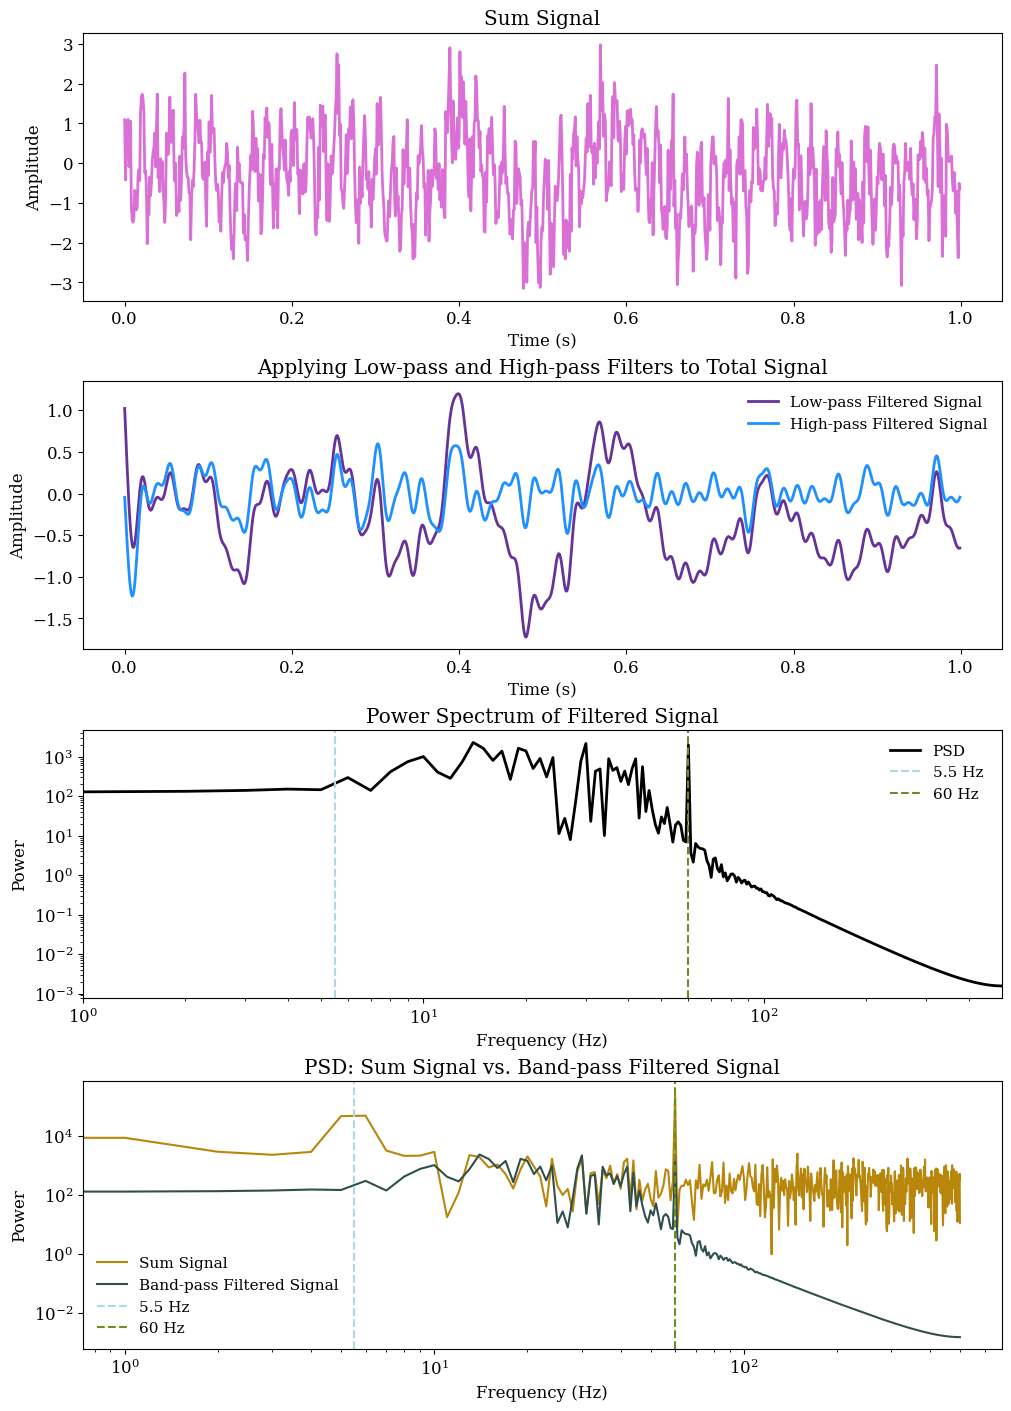

In [6]:
with plt.rc_context({'font.size': 12, 'font.family': 'serif'}): 
    low = 10
    high = 45

    lpb = butter(4, high, 'low', fs=fs, output='sos')
    lpf = sosfiltfilt(lpb, sumsignal)
    # filtfilt for zero-phase filtering (filters forward and back on a signal)

    hpb = butter(4, low, 'high', fs=fs, output='sos')
    hpf = sosfiltfilt(hpb, lpf)

    def psd(signaldata, samplerate):
        fftvals = fftpack.fft(signaldata)
        freqsvals = fftpack.fftfreq(len(signaldata), 1 / samplerate)
        psdvals = np.abs(fftvals) ** 2
        return freqsvals[:len(freqsvals)//2], psdvals[:len(psdvals)//2]

    fig, ax = plt.subplots(4, 1, figsize=(10, 14), constrained_layout=True)

    ax[0].plot(t, sumsignal, 'k', lw=2, color='orchid')
    ax[0].set_title('Sum Signal')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')

    ax[1].plot(t, lpf, label=f'Low-pass Filtered Signal', color='rebeccapurple', lw=2)
    ax[1].plot(t, hpf, label=f'High-pass Filtered Signal', color='dodgerblue', lw=2)
    ax[1].set_title('Applying Low-pass and High-pass Filters to Total Signal')
    ax[1].legend(frameon=False, prop={'size': 11, 'family': 'serif'})
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Amplitude')

    freqs, psdf = psd(hpf, fs)

    ax[2].loglog(freqs, psdf,label="PSD", color='black', lw=2 )
    ax[2].set_title('Power Spectrum of Filtered Signal')
    ax[2].set_xlabel('Frequency (Hz)')
    ax[2].set_ylabel('Power')
    ax[2].set_xlim(freqs[1], freqs[-1])

    ax[2].axvline(5.5, color=color_map["5.5Hz"], linestyle='--', label=f'5.5 Hz ')
    ax[2].axvline(60, color=color_map["Dirty60"], linestyle='--', label=f'60 Hz')
    ax[2].legend(frameon=False, prop={'size': 11, 'family': 'serif'})

    freqstot, psdtot = psd(sumsignal, fs)

    ax[3].loglog(freqstot, psdtot, label="Sum Signal", color="darkgoldenrod")
    ax[3].loglog(freqs, psdf, label="Band-pass Filtered Signal", color="darkslategrey", linestyle='-')

    ax[3].axvline(5.5, color=color_map["5.5Hz"], linestyle='--', label=f'5.5 Hz')
    ax[3].axvline(60, color=color_map["Dirty60"], linestyle='--', label=f'60 Hz')

    ax[3].set_title("PSD: Sum Signal vs. Band-pass Filtered Signal")
    ax[3].set_xlabel("Frequency (Hz)")
    ax[3].set_ylabel("Power")
    ax[3].legend(frameon=False, prop={'size': 11, 'family': 'serif'})

    plt.show()


#sorry joseph i tried my best for this part

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [7]:
#i feel like this part is pretty ez to get but anyways 

#data loading
desg = fits.getdata('DESJ053816.9-503050.8_g.fits')
desr = fits.getdata('DESJ053816.9-503050.8_r.fits')
desi = fits.getdata('DESJ053816.9-503050.8_i.fits')

spt = fits.getdata('SPT0538-50_SPT_220GHz.fits')
alma = fits.getdata('SPT0538-50_ALMA_870um.fits')

#cant just std over all data or else its inflated so have to sigma_clip it
#was this the curveball??
spt_clipped = sigma_clip(spt, sigma=3, maxiters=5)
alma_clipped = sigma_clip(alma, sigma=3, maxiters=5)

#getting std dev
sptnoise = np.std(spt_clipped)
almanoise = np.std(alma_clipped)

#getting signal to noise ratio
sptsnr = np.max(spt) / sptnoise
almasnr = np.max(alma) / almanoise

sptlevels = [sptnoise * level for level in [3, 5, 7, 9]]
almalevels = [almanoise * level for level in [5, 10, 15, 20]]

table = PrettyTable()
table.field_names = ["Parameter", "SPT", "ALMA"]

table.add_row(["Noise", f"{sptnoise:.5e}", f"{almanoise:.5e}"])
table.add_row(["Max SNR", f"{sptsnr:.5e}", f"{almasnr:.5e}"])
table.add_row(["3σ Contour Level", f"{sptlevels[0]:.30f}", "-"])
table.add_row(["5σ Contour Level", f"{sptlevels[1]:.30f}", f"{almalevels[0]:.30f}"])
table.add_row(["7σ Contour Level", f"{sptlevels[2]:.30f}", "-"])
table.add_row(["9σ Contour Level", f"{sptlevels[3]:.30f}", "-"])
table.add_row(["10σ Contour Level", "-", f"{almalevels[1]:.30f}"])
table.add_row(["15σ Contour Level", "-", f"{almalevels[2]:.30f}"])
table.add_row(["20σ Contour Level", "-", f"{almalevels[3]:.30f}"])

print(table)



+-------------------+----------------------------------+----------------------------------+
|     Parameter     |               SPT                |               ALMA               |
+-------------------+----------------------------------+----------------------------------+
|       Noise       |           7.64206e-05            |           4.58806e-04            |
|      Max SNR      |           8.91670e+00            |           5.73343e+01            |
|  3σ Contour Level | 0.000229261922702675251251047683 |                -                 |
|  5σ Contour Level | 0.000382103204504458788225151888 | 0.002294029771242068419662141210 |
|  7σ Contour Level | 0.000534944486306242325199256094 |                -                 |
|  9σ Contour Level | 0.000687785768108025753753143050 |                -                 |
| 10σ Contour Level |                -                 | 0.004588059542484136839324282420 |
| 15σ Contour Level |                -                 | 0.006882089313726205692

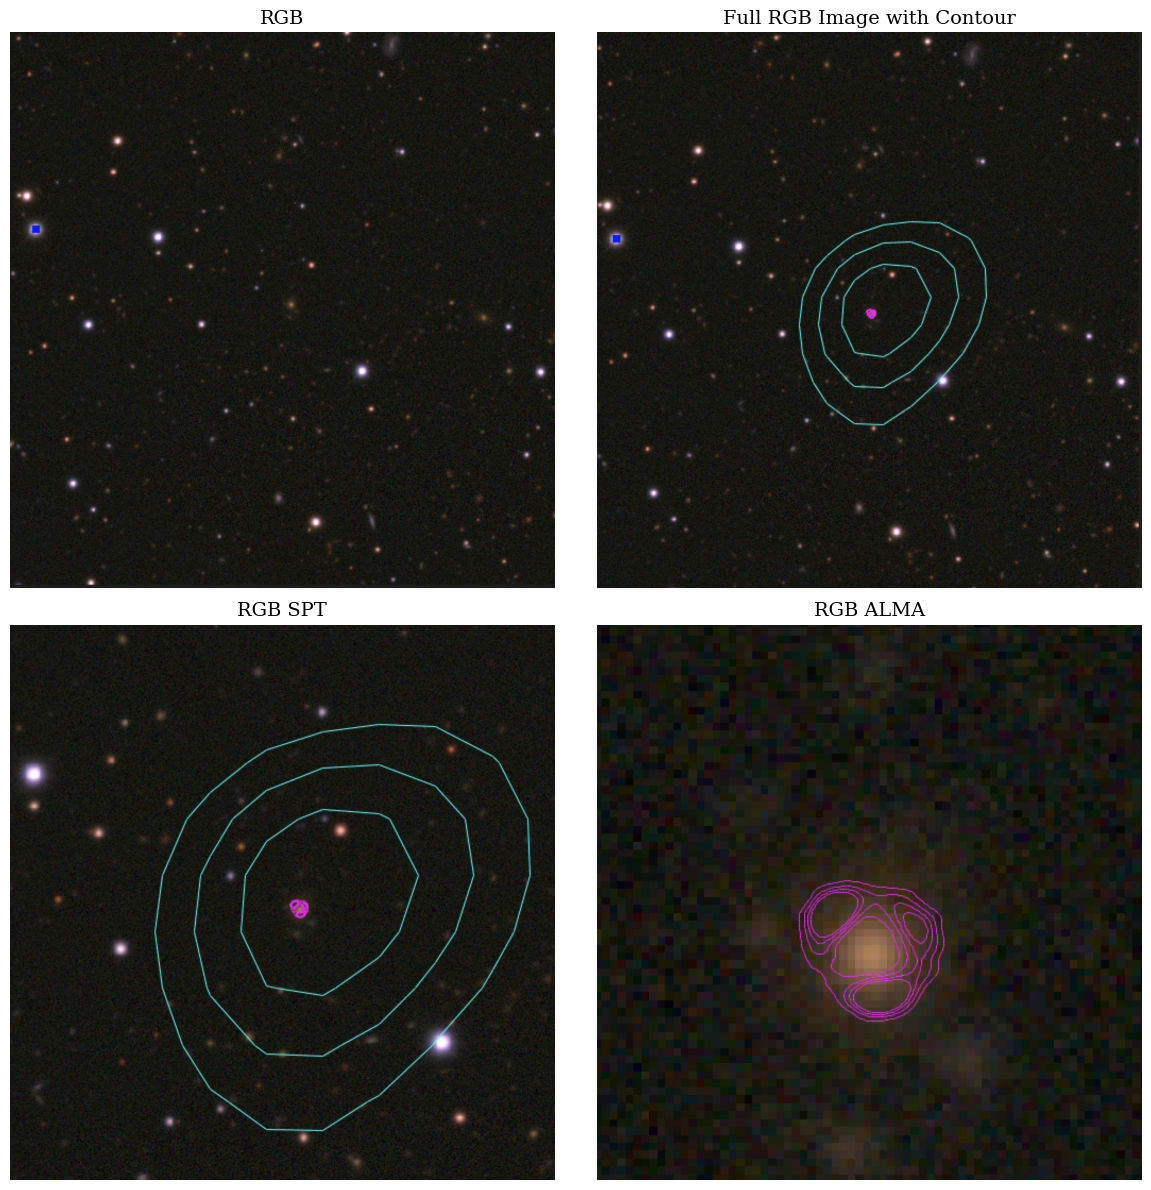

In [8]:

rgb = mpimg.imread('RGB.png')
rgbfullcont = mpimg.imread('RGBFullcontour.png')
rgbdcontzoomed = mpimg.imread('RGBContourbig.png')
rgbcontsmall = mpimg.imread('RGBContoursmall.png')

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].imshow(rgb)
axs[0, 0].set_title('RGB', fontsize=14, fontfamily='serif')
axs[0, 0].axis('off') 

axs[0, 1].imshow(rgbfullcont)
axs[0, 1].set_title('Full RGB Image with Contour', fontsize=14, fontfamily='serif')
axs[0, 1].axis('off')

axs[1, 0].imshow(rgbdcontzoomed)
axs[1, 0].set_title('RGB SPT', fontsize=14, fontfamily='serif')
axs[1, 0].axis('off')

axs[1, 1].imshow(rgbcontsmall)
axs[1, 1].set_title('RGB ALMA', fontsize=14, fontfamily='serif')
axs[1, 1].axis('off')

plt.tight_layout() #didnt feel like manually choosing how the widths btwn plots
#this might be my most useful plotting format

plt.show()

#I got the images in DS9, if u wanna quiz me on how to do it ill pass with flying colors
#thank you Liam Nolan for reminding me how to apply a pixel distribution 
#(Log scale, zscale, then adjust the parameters and color params for each band : P)

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [17]:
#if you see a value and your like ?! whered she get this?!
#Basic Astronomy for the Gnomonist, it was my holy grail 
#http://www.precisedirections.co.uk/Sundials/Basic%20Astronomy%20for%20the%20Gnomonist.pdf 

UClat = 40.112
UClong_hr = -88.221 / 15
day1 = datetime(2024, 1, 1)
totalDays = 366  #leap yeaaaar!!!! cant get me on this one 
latRad = np.radians(UClat)

#Fixed orthog rotation matrix for ICRS and galactic coordinate system
#I learned more about the use of this on the Gaia data release documentation
#on Gaia website its 3.61 under "3.1.7 Transformations of astrometric data and error propagation"
#https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html
#i couldve done multiple things like sin(dec)*delta-cos(dec..... bla bla but this way is more fun
rotMatrix = np.array([[-0.05487556, -0.87343709, -0.48383502],
                      [ 0.49410943, -0.44482963,  0.74698224],
                      [-0.86766615, -0.19807637,  0.45598378]])

#RA hrminsec to degree
def RADEC2DEG(raHrs, raMin, raSec, decDeg):
    return (raHrs + raMin / 60 + raSec / 3600) * 15, decDeg

#equitorial coord to 3d cartesian 
def eq2Vec(raDeg, decDeg):
    raRad, decRad = np.radians(raDeg), np.radians(decDeg)
    return np.array([np.cos(decRad) * np.cos(raRad), np.cos(decRad) * np.sin(raRad), np.sin(decRad)])

#3d vector in eq coords to galactic coords, ROTATION MATRIX TIME!!!!
def vec2Gal(vecCoords):
    galCoords = rotMatrix @ vecCoords
    dist = np.linalg.norm(galCoords)
    galLon = np.degrees(np.arctan2(galCoords[1], galCoords[0])) % 360
    galLat = np.degrees(np.arcsin(galCoords[2] / dist))
    return galLon, galLat

def eq2Gal(raDeg, decDeg):
    return vec2Gal(eq2Vec(raDeg, decDeg))

def KingJulian(date): #I LOVE YOU KING JULIANNNNN 
    y, m, d = date.year, date.month, date.day
    if m <= 2: #adjusting Jan and Feb, cant get me here either, i even got the correction for centuries
        y -= 1
        m += 12
    A = np.floor(y / 100)
    B = 2 - A + np.floor(A / 4)
    return np.floor(365.25 * (y + 4716)) + np.floor(30.6001 * (m + 1)) + d + B - 1524.5


#gets GMST in hr for given jd
def GMSTcalc(jd):
    Jan1jd = 2451545.0
    cent = (jd - Jan1jd) / 36525.0 
    GMST = (280.46061837 + 360.98564736629 * (jd - Jan1jd) + 0.000387933 * cent**2 - (cent**3 / 38710000.0)) % 360
    return GMST / 15
#it was at this moment in writing i knew i was screwed, but then i found basic astronomy for the gnomonist!

#i dont like ben franklin for making this, also cant get me here EITHER!!!!!!
def daylightsavings(day, time):
    dst_start = datetime(2024, 3, 10)
    dst_end = datetime(2024, 11, 3)
    if day < dst_start or day > dst_end:
        return -6
    elif day > dst_start and day < dst_end:
        return -5
    elif day == dst_start:
        return -6 if time < 2 else -5  # DST starts at 2 AM
    elif day == dst_end:
        return -5 if time < 2 else -6  # DST ends at 2 AM

#where the magic happens thank you Lecture 6 slide 51
def riseset(raDeg, decDeg, day):
    raHrs = raDeg / 15
    HA = np.degrees(np.arccos(-np.tan(latRad) * np.tan(np.radians(decDeg)))) / 15  # hour angle and converting

    LSTRise = (24 + raHrs - HA) % 24
    LSTSet = (raHrs + HA) % 24
    
    GSTRise = (LSTRise - UClong_hr) % 24
    GSTSet = (LSTSet - UClong_hr) % 24
    
    jd = KingJulian(day)
    GMST = GMSTcalc(jd)
    UTcalc = lambda t: (t - GMST) % 24
#i love the lambda function 
    dst_rise = daylightsavings(day, UTcalc(GSTRise))
    dst_set = daylightsavings(day, UTcalc(GSTSet))

    localRise = (UTcalc(GSTRise) + dst_rise) % 24
    localSet = (UTcalc(GSTSet) + dst_set) % 24
    
    return localRise, localSet


#this is where I make it so you can see the magic
def plotriseset(raDeg, decDeg):
    times = np.array([riseset(raDeg, decDeg, day1 + timedelta(days=d)) for d in range(totalDays)])
    
    #getting rid of the continuous wrapping from 0 to 24 (the weird vertical lines ewww)
    def creatediscontinuouslines(times):
        nolines = np.copy(times)
        nolines[np.abs(np.diff(times, prepend=times[0])) > 12] = np.nan
        return nolines

    rising = creatediscontinuouslines(times[:, 0])
    setting = creatediscontinuouslines(times[:, 1])

    days = np.arange(1, totalDays + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(days, rising, label="Rise", color='darkslateblue')
    plt.plot(days, setting, label="Set", color='deeppink')

    plt.fill_between(days, rising, setting, where=(rising < setting), color='lightpink', alpha=0.25)

    plt.fill_between(days, 0, setting, where=(rising > setting), color='lightpink', alpha=0.25)
    plt.fill_between(days, rising, 24, where=(rising > setting),  color='lightpink', alpha=0.25)
    
    plt.title('Vega Rise and Set Times for 2024', fontsize=16, fontfamily='serif')
    plt.xlabel('Day of Year', fontsize=14, fontfamily='serif')
    plt.ylabel('Central Time (Hrs)', fontsize=14, fontfamily='serif')
    
    #making the labels pretty
    yTicks = np.arange(0, 25, 1)
    plt.yticks(yTicks, [f'{int(hour):02d}:00' for hour in yTicks], fontsize=11, fontfamily='serif')
    
    xticks = np.linspace(1, totalDays, 24)
    plt.xticks(xticks, [(day1 + timedelta(days=int(i-1))).strftime('%m-%d') for i in xticks], rotation=45, fontsize=12, fontfamily='serif')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False, prop={'size': 14, 'family': 'serif'})
    plt.ylim(-1, 25)
    plt.show()

    
#this was originally for checking that the times outputted right 
#but i kept it bc y not 
def risesettimeshrs(hours):
    hrs, mins = divmod(int(hours * 60), 60)
    return f"{hrs:02d}:{mins:02d}"

def printingfunc(raDeg, decDeg, date):
    day = datetime.strptime(date, '%Y-%m-%d')
    rise, set = riseset(raDeg, decDeg, day)
    print(f"Rise time on {date}: {risesettimeshrs(rise)}")
    print(f"Set time on {date}: {risesettimeshrs(set)}")



Vega's Equatorial Coordinates: RA = 279.23333°, Dec = 38.78361°
Vega's Galactic Coordinates: lon = 67.44773°, lat = 19.23825°
Rise time on 2024-03-09: 22:30
Set time on 2024-03-09: 16:11
Rise time on 2024-03-10: 23:26
Set time on 2024-03-10: 17:07
Rise time on 2024-10-20: 08:43
Set time on 2024-10-20: 02:24


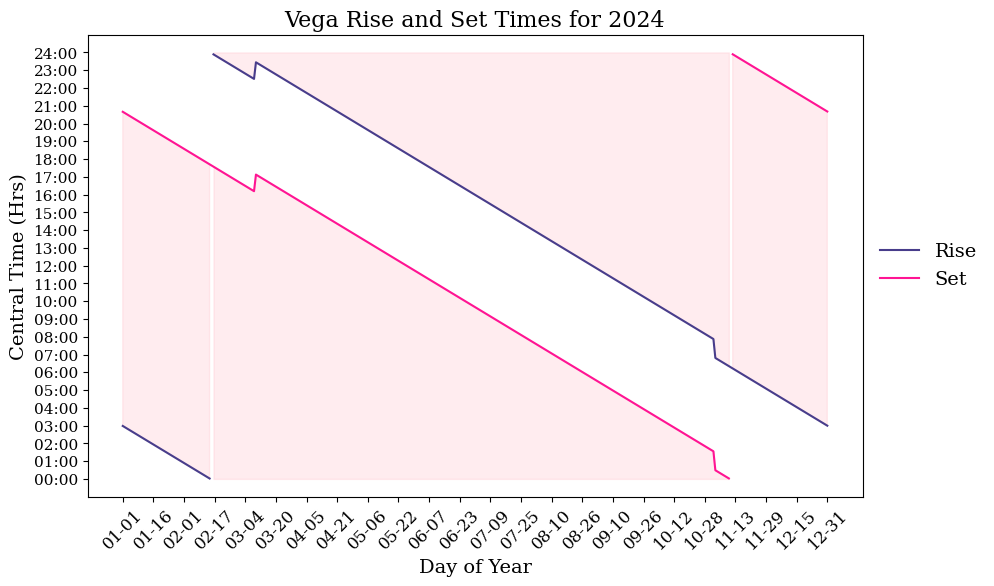

In [20]:
def main():
    raDeg, decDeg = RADEC2DEG(18, 36, 56, 38 + 47 / 60 + 1 / 3600)
    print(f"Vega's Equatorial Coordinates: RA = {raDeg:.5f}°, Dec = {decDeg:.5f}°")
    galacticLon, galacticLat = eq2Gal(raDeg, decDeg)
    print(f"Vega's Galactic Coordinates: lon = {galacticLon:.5f}°, lat = {galacticLat:.5f}°")
    printingfunc(raDeg, decDeg, '2024-03-09')
    printingfunc(raDeg, decDeg, '2024-03-10')
    printingfunc(raDeg, decDeg, '2024-10-20')
    plotriseset(raDeg, decDeg)

if __name__ == "__main__":
    main()


### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!